<a href="https://colab.research.google.com/github/Onamihoang/CIFAR10_DL01/blob/master/CIFAR100_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD


In [0]:
batch_size = 64    
epochs = 30 
data_augmentation = False
num_classes = 100

In [15]:
# Load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", x_train.shape)
print("The shape of X_test : ", x_test.shape)

The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


[52 29 75 78  0]


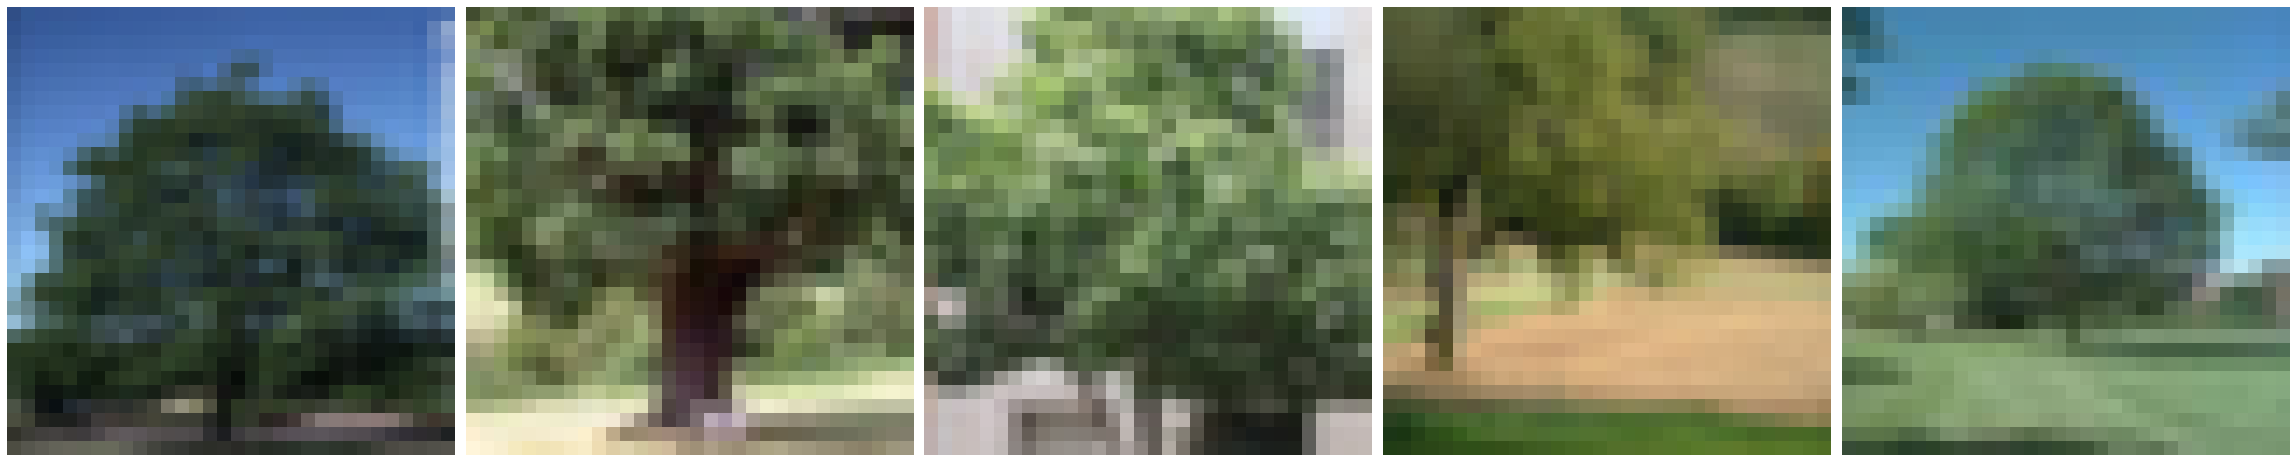

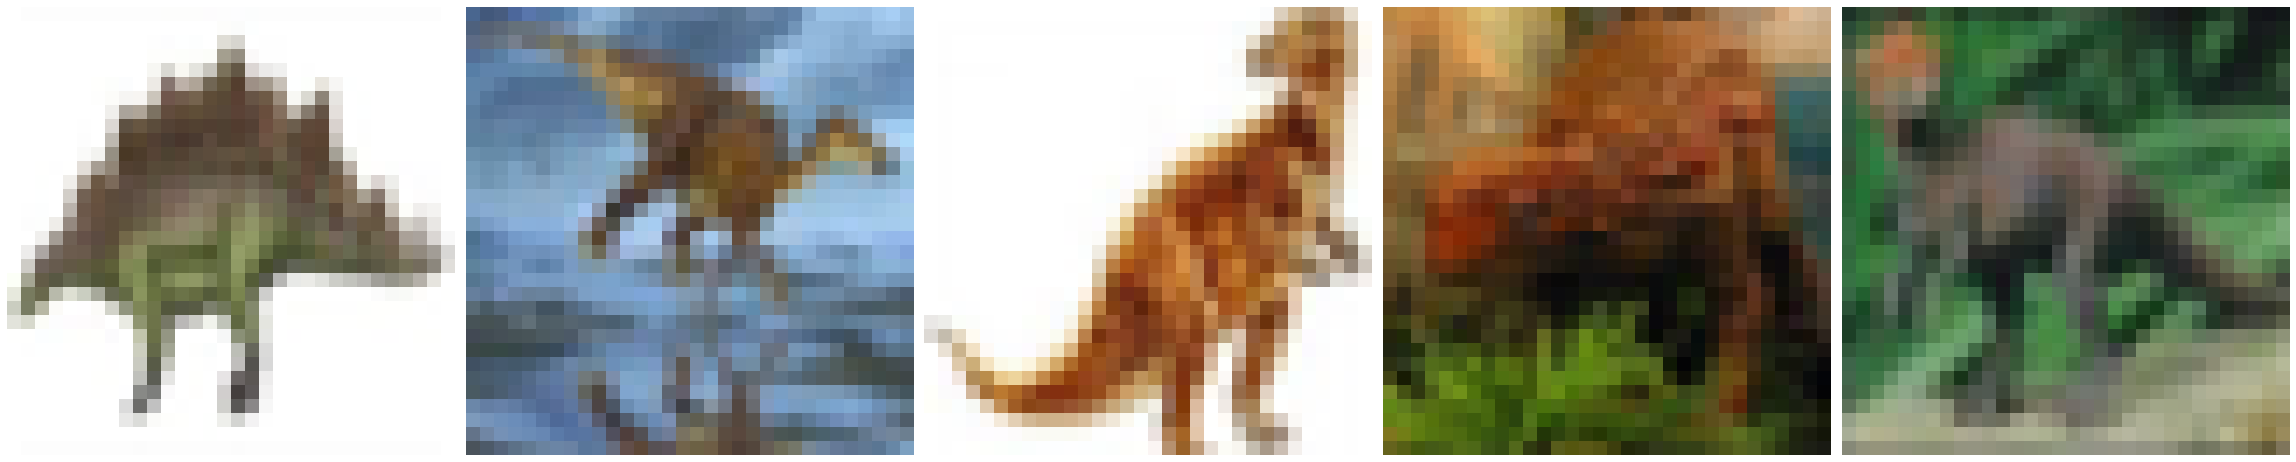

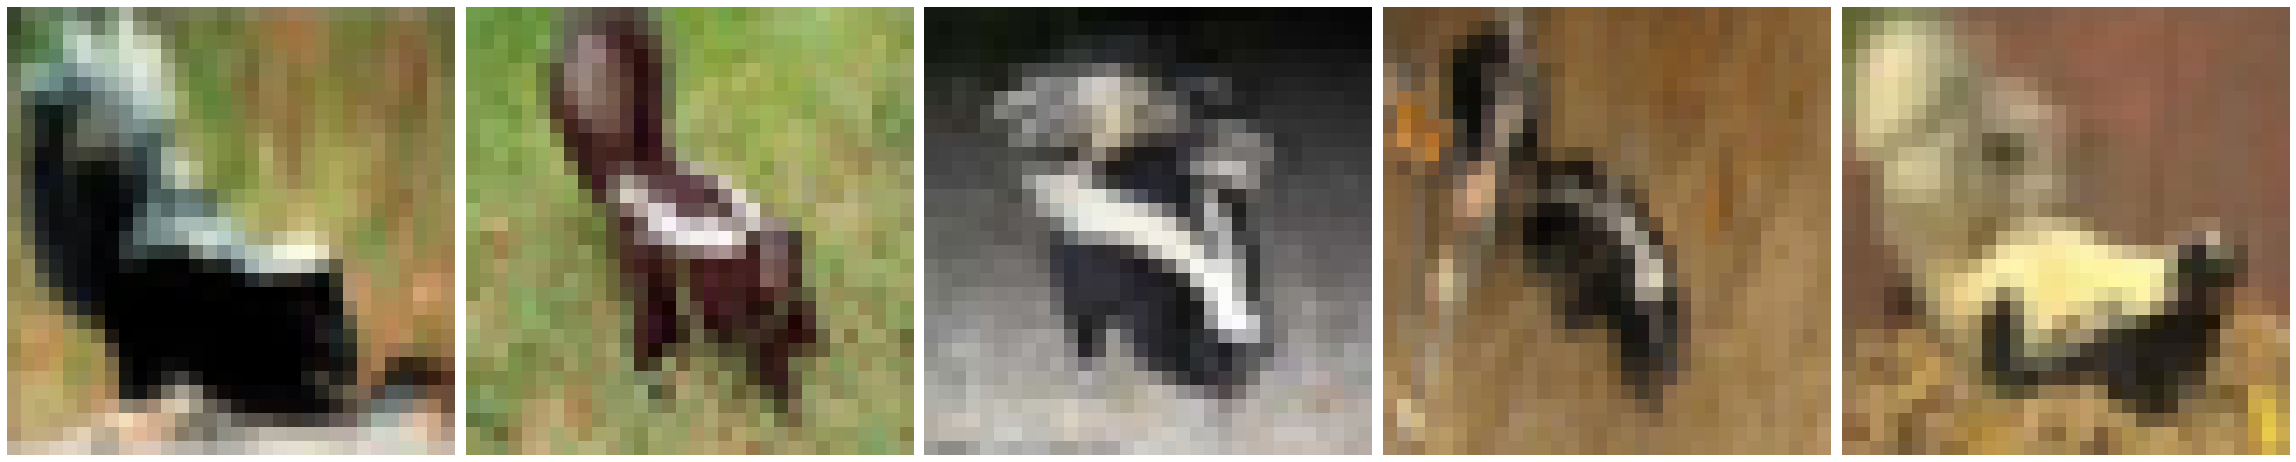

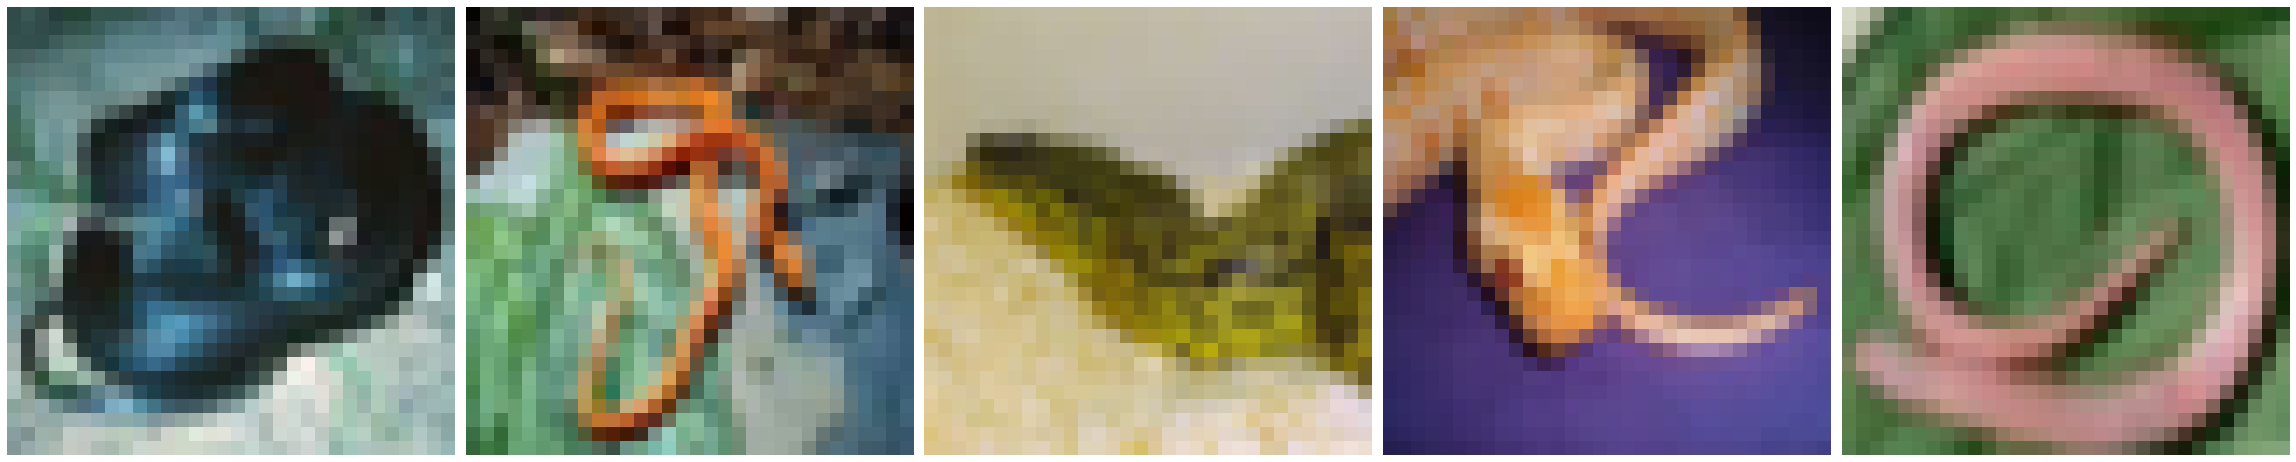

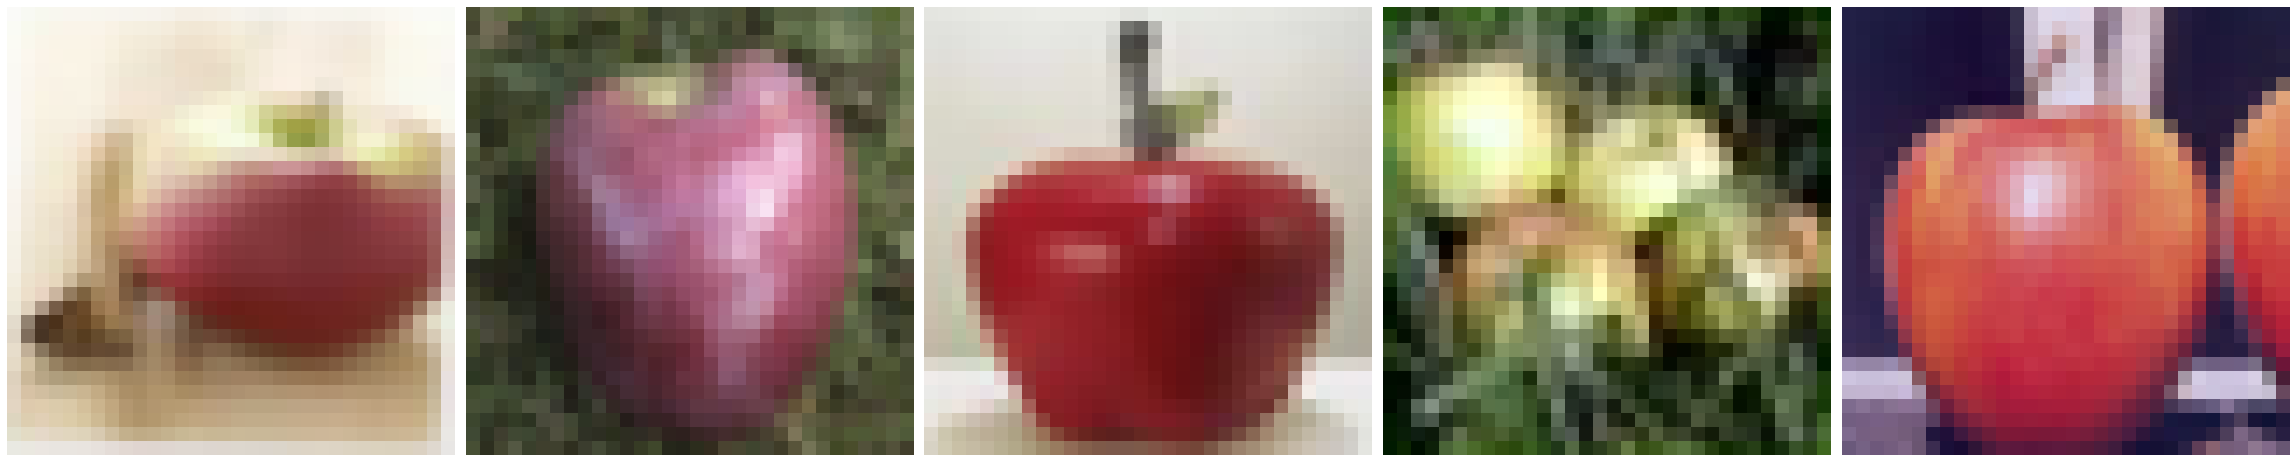

In [16]:
class_plotted = np.random.choice(range(num_classes), 5, replace = False)
print(class_plotted)
for i in range(len(class_plotted)):
    image_samples = x_train[y_train.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (32,32))
    #fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show() 

In [0]:
# Input image dimensions
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Draw figure 
def summarize_diagnostics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = "VGG"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [20]:
'''
# VGG 1 Block 

VGG1_model = Sequential()
VGG1_model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(MaxPool2D((2, 2)))
VGG1_model.add(Dropout(0.2))

VGG1_model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(MaxPool2D((2, 2)))
VGG1_model.add(Dropout(0.3))

VGG1_model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(MaxPool2D((2, 2)))
VGG1_model.add(Dropout(0.4))

VGG1_model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(MaxPool2D((2, 2)))
VGG1_model.add(Dropout(0.5))

VGG1_model.add(Flatten())
VGG1_model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
VGG1_model.add(BatchNormalization())
VGG1_model.add(Dropout(0.5))
VGG1_model.add(Dense(100, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop()

# SGD optimizer
#opt = SGD(lr=0.001, momentum=0.9)

#optimization details
#opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

VGG1_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    VGG1_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    VGG1_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

VGG1_model.summary()
'''

'\n# VGG 1 Block \n\nVGG1_model = Sequential()\nVGG1_model.add(Conv2D(64, (3, 3), activation=\'elu\', kernel_initializer=\'he_uniform\', padding=\'same\', input_shape=(32, 32, 3)))\nVGG1_model.add(BatchNormalization())\nVGG1_model.add(Conv2D(64, (3, 3), activation=\'elu\', kernel_initializer=\'he_uniform\', padding=\'same\'))\nVGG1_model.add(BatchNormalization())\nVGG1_model.add(MaxPool2D((2, 2)))\nVGG1_model.add(Dropout(0.2))\n\nVGG1_model.add(Conv2D(128, (3, 3), activation=\'elu\', kernel_initializer=\'he_uniform\', padding=\'same\'))\nVGG1_model.add(BatchNormalization())\nVGG1_model.add(Conv2D(128, (3, 3), activation=\'elu\', kernel_initializer=\'he_uniform\', padding=\'same\'))\nVGG1_model.add(BatchNormalization())\nVGG1_model.add(MaxPool2D((2, 2)))\nVGG1_model.add(Dropout(0.3))\n\nVGG1_model.add(Conv2D(256, (3, 3), activation=\'elu\', kernel_initializer=\'he_uniform\', padding=\'same\'))\nVGG1_model.add(BatchNormalization())\nVGG1_model.add(Conv2D(256, (3, 3), activation=\'elu\', 

In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# Let's train the model using RMSprop
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
'''
h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
'''
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)



# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) / 32,
                    epochs=epochs, verbose=1, workers=4)





# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1563/1562 [==============================] - 61s 39ms/step - loss: 0.9000 - accuracy: 0.7520 - val_loss: 1.5247 - val_accuracy: 0.6418
Epoch 22/30
1563/1562 [==============================] - 61s 39ms/step - loss: 0.8646 - accuracy: 0.7617 - val_loss: 1.4389 - val_accuracy: 0.6573
Epoch 23/30
1563/1562 [==============================] - 61s 39ms/step - loss: 0.8315 - accuracy: 0.7710 - val_loss: 1.4843 - val_accuracy: 0.6577
Epoch 24/30
1563/1562 [==============================] - 61s 39ms/step - loss: 0.8011 - accuracy: 0.7787 - val_loss: 1.5344 - val_accuracy: 0.6487
Epoch 25/30
1563/1562 [==============================] - 60s 39ms/step - loss: 0.7701 - accuracy: 0.7867 - val_loss: 1.5412 - val_accuracy: 0.6504
Epoch 26/30
1563/1562 [==============================] - 60s 39ms/step - loss: 0.7456 - accuracy: 0.7941 - val_loss: 1.4685 - val_accuracy: 0.6628
Epoch 27/30
1563/1562 [==============================] - 61s 39ms/step - loss: 0.7168 - accuracy: 0.8009 - val_loss: 1.4958 - val_

In [22]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 1.9229 - accuracy: 0.6045
Test loss: 1.9228754043579102
Test accuracy: 0.6044999957084656


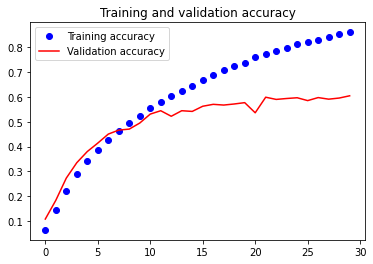

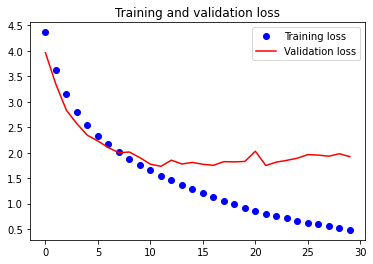

In [23]:

summarize_diagnostics(h)